In [72]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
!ls "/content/drive/My Drive/score_tables"


handwritten_marks_dataset.zip  score_tables.zip


In [74]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms



In [75]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Define the dataset class
class HandwrittenDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Read dataset and store image paths and corresponding labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(float(label))  # Convert label to float

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [76]:
import zipfile
zip_path = '/content/drive/My Drive/score_tables/handwritten_marks_dataset.zip'
extracted_path = '/content/handwritten_marks_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)


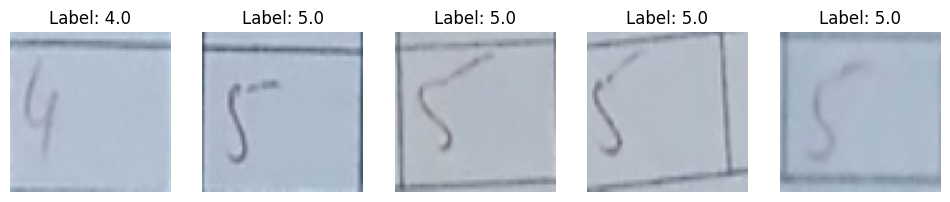

In [77]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

# Define paths after extracting the dataset in Colab
base_dir = '/content/handwritten_marks_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define transformations with resizing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Create datasets using your custom HandwrittenDataset class
train_dataset = HandwrittenDataset(train_dir, transform=transform)
test_dataset = HandwrittenDataset(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize sample images
def visualize_data(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        img = images[i].permute(1, 2, 0).numpy()  # Convert to NumPy array for plotting
        axes[i].imshow((img * 0.5) + 0.5)  # Undo normalization for visualization
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

# Call the visualization function
visualize_data(train_loader)


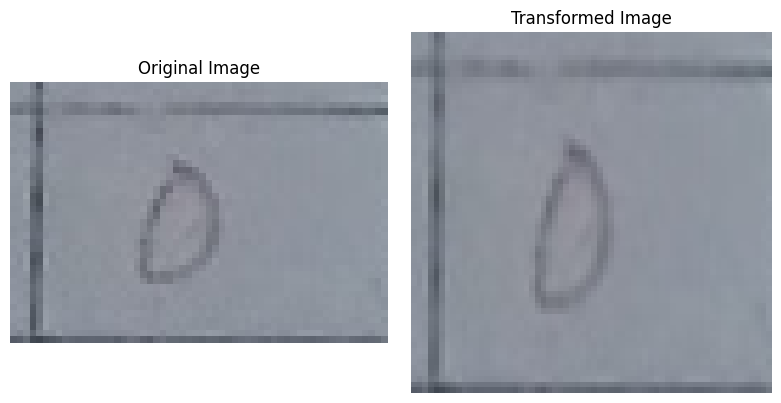

In [78]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Define transformations with resizing and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize image
])

# Path to a sample image from the dataset (adjust path as needed)
image_path = '/content/handwritten_marks_dataset/train/0/17_1.png'
original_image = Image.open(image_path).convert("RGB")  # Convert to RGB mode

# Applying the transformations
transformed_image = transform(original_image)

# Converting transformed image back to a format that can be visualized (denormalize)
transformed_image_denormalized = transformed_image * 0.5 + 0.5  # Undo normalization
transformed_image_denormalized = transformed_image_denormalized.permute(1, 2, 0)  # Convert from CxHxW to HxWxC

# Plotting original and transformed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display original image
axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Display transformed (denormalized) image
axes[1].imshow(transformed_image_denormalized.numpy())
axes[1].axis('off')
axes[1].set_title('Transformed Image')

plt.tight_layout()
plt.show()


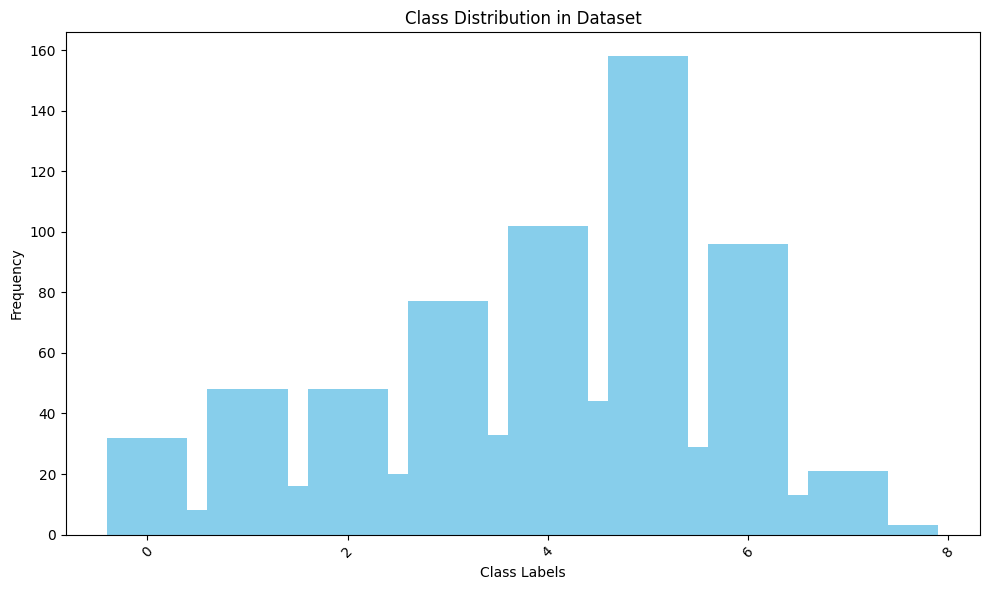

Class weights: {7.5: 15.583333333333334, 4.0: 0.4583333333333333, 1.0: 0.9739583333333334, 3.0: 0.6071428571428571, 2.5: 2.3375, 4.5: 1.0625, 0.5: 5.84375, 2.0: 0.9739583333333334, 0.0: 1.4609375, 5.5: 1.6120689655172413, 7.0: 2.2261904761904763, 5.0: 0.2958860759493671, 6.5: 3.5961538461538463, 1.5: 2.921875, 3.5: 1.4166666666666667, 6.0: 0.4869791666666667}
Weight tensor: tensor([ 1.4609,  5.8438,  0.9740,  2.9219,  0.9740,  2.3375,  0.6071,  1.4167,
         0.4583,  1.0625,  0.2959,  1.6121,  0.4870,  3.5962,  2.2262, 15.5833])


In [79]:
import matplotlib.pyplot as plt
import torch
from collections import Counter

# Function to calculate class weights and plot class distribution
def calculate_class_weights_and_plot(dataset):
    # Check if dataset has an attribute 'labels'
    if not hasattr(dataset, 'labels'):
        raise AttributeError("The dataset object must have a 'labels' attribute containing class labels.")

    # Counting the frequency of each class in the dataset
    class_counts = Counter(dataset.labels)
    total_samples = len(dataset)

    # Calculating class weights
    class_weights = {key: total_samples / (len(class_counts) * count) for key, count in class_counts.items()}

    # Plotting the class distribution
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return class_weights

# First calculate class weights and plot the class distribution
class_weights = calculate_class_weights_and_plot(train_dataset)

# Printing the calculated class weights
print("Class weights:", class_weights)

# Ensure weights are assigned correctly, using the actual keys from class_weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_tensor = torch.tensor(
    [class_weights[key] for key in sorted(class_weights.keys())], dtype=torch.float32
).to(device)

# Printing the class weight tensor for verification
print("Weight tensor:", weight_tensor)


In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=16):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # Assuming input images are 64x64
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_block(x)
        return x

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=16).to(device)


In [81]:
import torch.nn as nn
import torch.optim as optim

# Ensure weight_tensor is on the same device as the model
weight_tensor = weight_tensor.to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/15], Loss: 1.9932, Accuracy: 18.58%
Epoch [2/15], Loss: 1.7870, Accuracy: 22.06%
Epoch [3/15], Loss: 1.7818, Accuracy: 19.39%
Epoch [4/15], Loss: 1.6808, Accuracy: 22.99%
Epoch [5/15], Loss: 1.6283, Accuracy: 25.40%
Epoch [6/15], Loss: 1.5628, Accuracy: 26.20%
Epoch [7/15], Loss: 1.5198, Accuracy: 32.22%
Epoch [8/15], Loss: 1.3100, Accuracy: 43.05%
Epoch [9/15], Loss: 1.1519, Accuracy: 47.46%
Epoch [10/15], Loss: 1.0540, Accuracy: 53.61%
Epoch [11/15], Loss: 0.8539, Accuracy: 58.82%
Epoch [12/15], Loss: 0.6841, Accuracy: 68.58%
Epoch [13/15], Loss: 0.5091, Accuracy: 75.40%
Epoch [14/15], Loss: 0.3716, Accuracy: 83.29%
Epoch [15/15], Loss: 0.2848, Accuracy: 85.83%


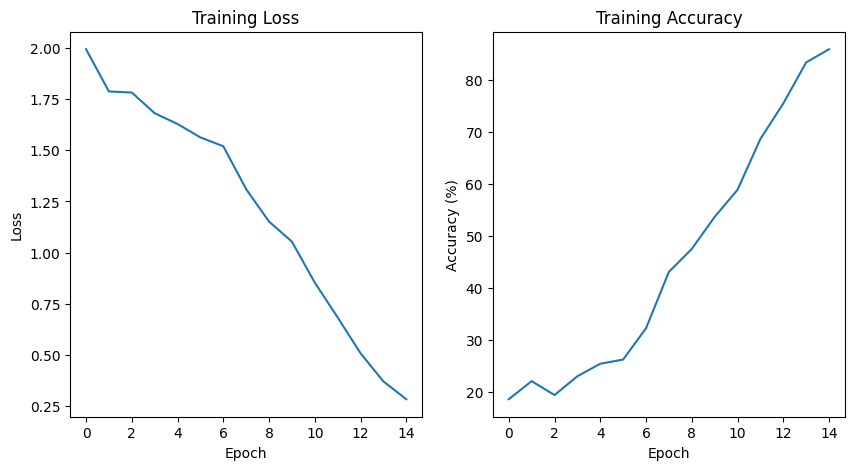

In [82]:
# Train the model
num_epochs = 15
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels to Long type (torch.int64) before passing to loss function
        labels = labels.long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Visualize training loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')

plt.show()


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Evaluate the model
model.eval()
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Convert continuous labels to integers (round or floor, as needed)
        labels = torch.round(labels).long()  # Round labels to nearest integer and convert to Long

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6393
Precision: 0.6723
Recall: 0.6393
F1 Score: 0.6233


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


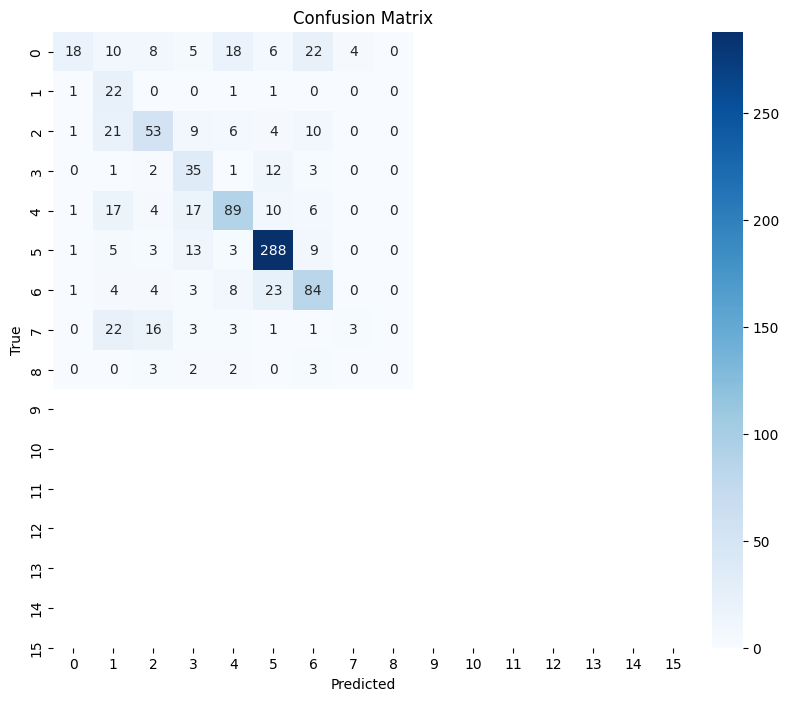

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
# print(len(test_labels), len(test_predictions))
# print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(16), yticklabels=range(16))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [85]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from collections import Counter

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming 'train_dataset' is already defined and contains labels
class_counts = Counter(train_dataset.labels)  # Get counts of each class
total_samples = len(train_dataset)

# Calculate class weights (inverse frequency)
class_weights = {key: total_samples / (len(class_counts) * count) for key, count in class_counts.items()}

# Ensure the class labels in `class_weights` are in the correct order (from 0 to 15 in your case)
# Create a list of weights for the 16 classes (assuming class labels range from 0 to 15)
weight_tensor = torch.tensor([class_weights[i] if i in class_weights else 0 for i in range(16)], dtype=torch.float32).to(device)

# Load the pre-trained ResNet-18 model
pretrained_model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 16)

# Move the model to device (GPU or CPU)
pretrained_model = pretrained_model.to(device)

# Define the loss function with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Fine-tune the model
num_epochs = 5
for epoch in range(num_epochs):
    pretrained_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels to Long type as expected by CrossEntropyLoss
        labels = labels.long()

        optimizer.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 1.2983, Accuracy: 58.69%
Epoch [2/5], Loss: 0.5643, Accuracy: 82.09%
Epoch [3/5], Loss: 0.3164, Accuracy: 90.24%
Epoch [4/5], Loss: 0.2029, Accuracy: 94.39%
Epoch [5/5], Loss: 0.1874, Accuracy: 95.05%


In [86]:
def forward(self, inputs, targets):
    logpt = nn.functional.log_softmax(inputs, dim=-1)
    pt = torch.exp(logpt)
    # Gather probabilities for target classes
    pt = torch.gather(pt, dim=1, index=targets.unsqueeze(1)).squeeze(1)
    logpt = torch.gather(logpt, dim=1, index=targets.unsqueeze(1)).squeeze(1)

    loss = - (1 - pt) ** self.gamma * logpt
    if self.alpha is not None:
        alpha_t = self.alpha[targets]
        loss = alpha_t * loss

    if self.reduction == 'mean':
        return loss.mean()
    elif self.reduction == 'sum':
        return loss.sum()
    else:
        return loss

# Scheduler integration
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for epoch in range(num_epochs):
    pretrained_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/5], Loss: 0.1847, Accuracy: 95.72%
Epoch [2/5], Loss: 0.2496, Accuracy: 92.91%
Epoch [3/5], Loss: 0.0921, Accuracy: 97.59%
Epoch [4/5], Loss: 0.0387, Accuracy: 98.66%
Epoch [5/5], Loss: 0.0341, Accuracy: 99.47%


In [87]:
# Evaluate the model
model.eval()
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Convert continuous labels to integers (round or floor, as needed)
        labels = torch.round(labels).long()  # Round labels to nearest integer and convert to Long

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())


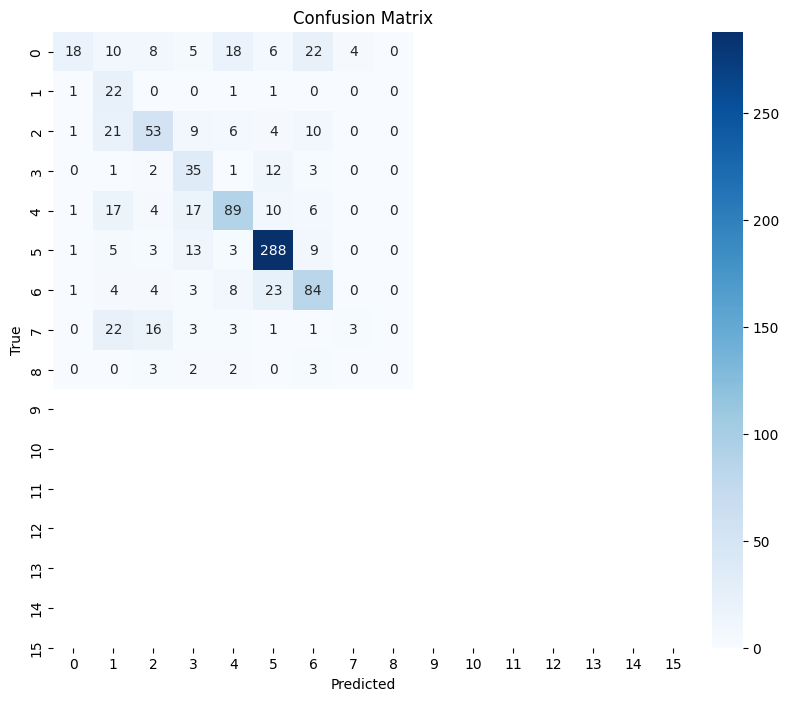

In [88]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
# print(len(test_labels), len(test_predictions))
# print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(16), yticklabels=range(16))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [89]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")

Model saved as model.pth


Contents of extracted_path: ['score_tables']
Found 56 image files.
Processing sample image: /content/score_tables/score_tables/image52.png


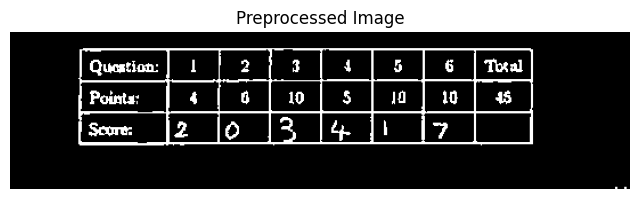

In [90]:
import zipfile
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define paths
zip_path = '/content/drive/My Drive/score_tables/score_tables.zip'
extracted_path = '/content/score_tables'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List the contents of the extracted folder
print("Contents of extracted_path:", os.listdir(extracted_path))

# Recursively collect valid image files from the extracted directory
image_files = []
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_files.append(os.path.join(root, file))

if not image_files:
    raise ValueError("No valid image files found in the specified directory or its subdirectories.")

print(f"Found {len(image_files)} image files.")

# Function to preprocess images
def preprocess_image(image_path):
    """Preprocess the image: read in grayscale, apply binary threshold."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded.")
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
    return binary_image

# Use the first image for demonstration
sample_image_path = image_files[10]
print(f"Processing sample image: {sample_image_path}")

# Preprocess and display the image
binary_image = preprocess_image(sample_image_path)

plt.figure(figsize=(8, 6))
plt.imshow(binary_image, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


In [91]:
!pip install pytesseract


In [92]:
!apt-get update
!apt-get install -y tesseract-ocr


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (155 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [93]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


Loading image: /content/score_tables/score_tables/image19.png


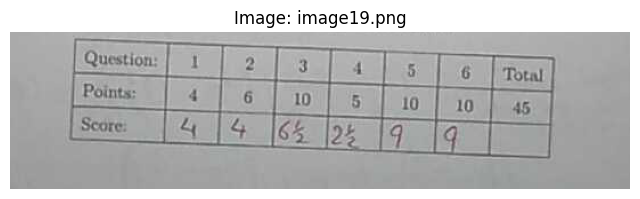

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image1.txt
Loading image: /content/score_tables/score_tables/image17.png


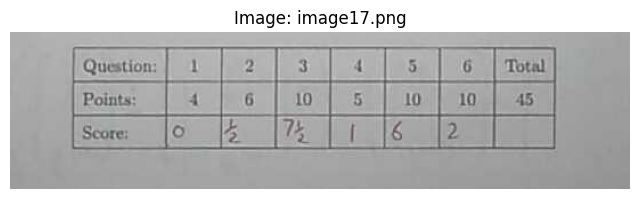

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image2.txt
Loading image: /content/score_tables/score_tables/image53.png


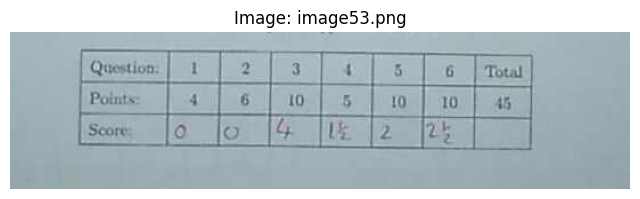

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image3.txt
Loading image: /content/score_tables/score_tables/image31.png


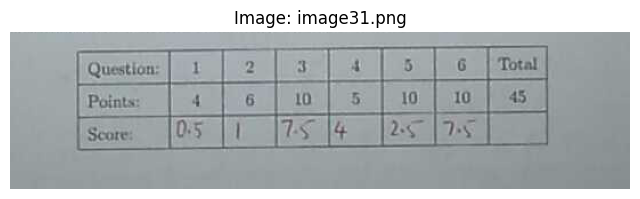

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image4.txt
Loading image: /content/score_tables/score_tables/image9.png


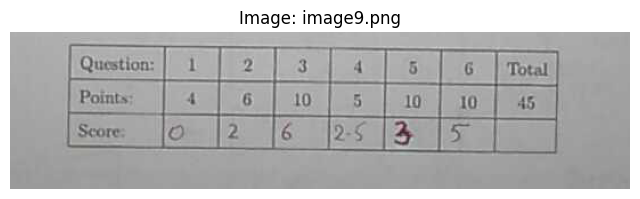

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image5.txt
Loading image: /content/score_tables/score_tables/image51.png


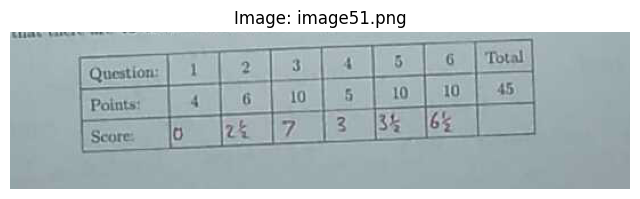

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image6.txt
Loading image: /content/score_tables/score_tables/image23.png


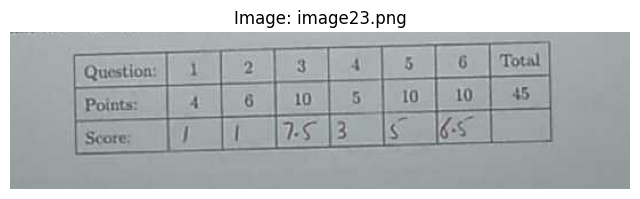

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image7.txt
Loading image: /content/score_tables/score_tables/image29.png


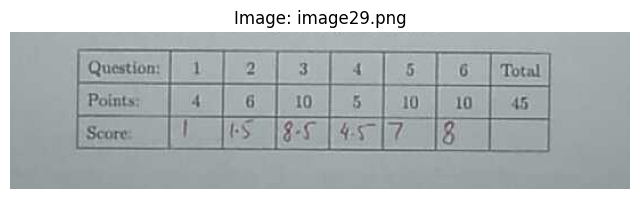

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image8.txt
Loading image: /content/score_tables/score_tables/image48.png


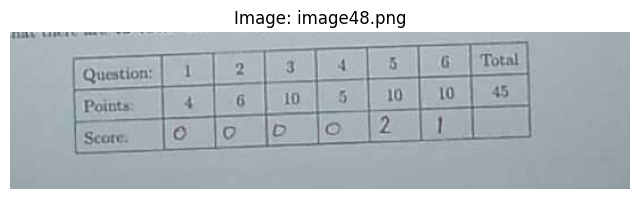

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image9.txt
Loading image: /content/score_tables/score_tables/image26.png


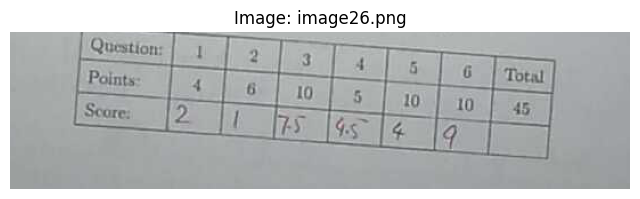

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image10.txt
Loading image: /content/score_tables/score_tables/image52.png


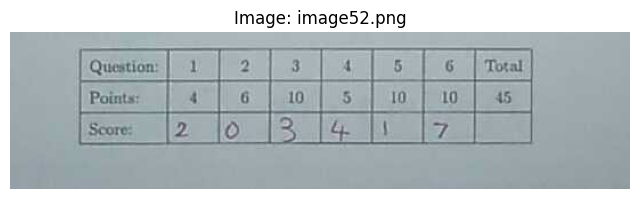

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image11.txt
Loading image: /content/score_tables/score_tables/image7.png


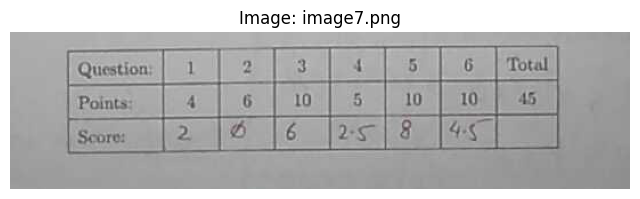

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image12.txt
Loading image: /content/score_tables/score_tables/image20.png


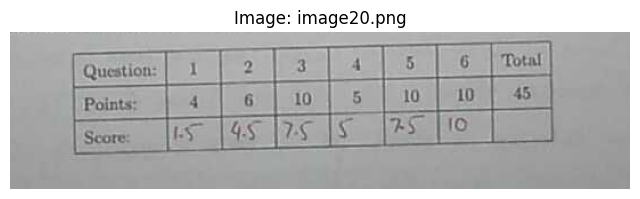

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image13.txt
Loading image: /content/score_tables/score_tables/image45.png


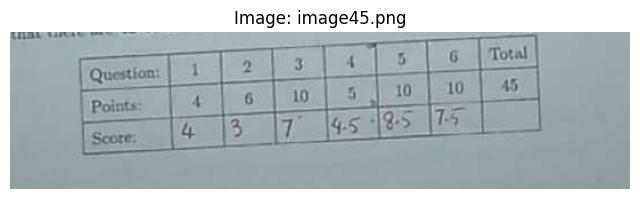

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image14.txt
Loading image: /content/score_tables/score_tables/image33.png


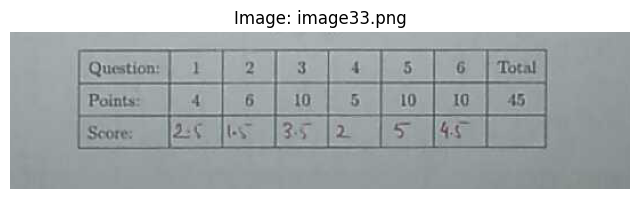

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image15.txt
Loading image: /content/score_tables/score_tables/image56.png


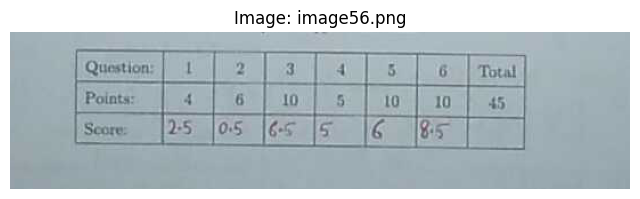

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image16.txt
Loading image: /content/score_tables/score_tables/image25.png


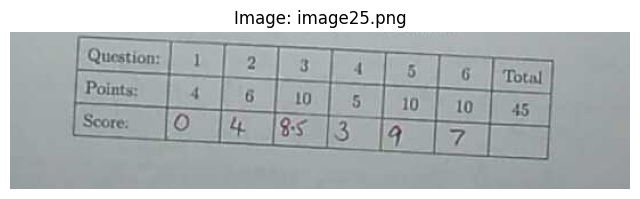

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image17.txt
Loading image: /content/score_tables/score_tables/image27.png


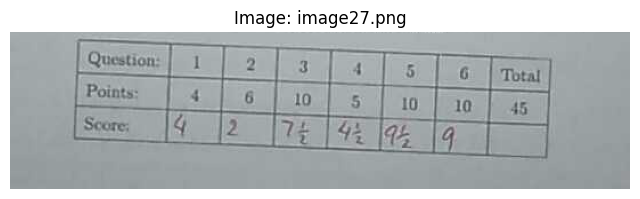

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image18.txt
Loading image: /content/score_tables/score_tables/image18.png


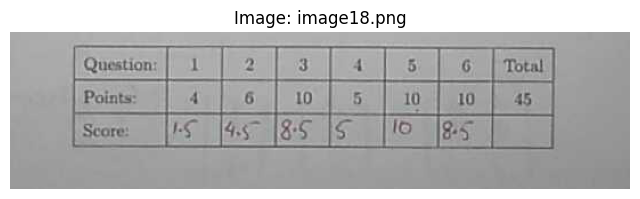

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image19.txt
Loading image: /content/score_tables/score_tables/image28.png


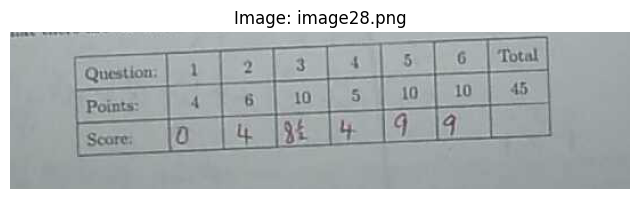

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image20.txt
Loading image: /content/score_tables/score_tables/image54.png


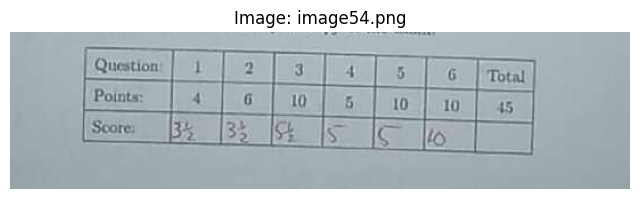

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image21.txt
Loading image: /content/score_tables/score_tables/image4.png


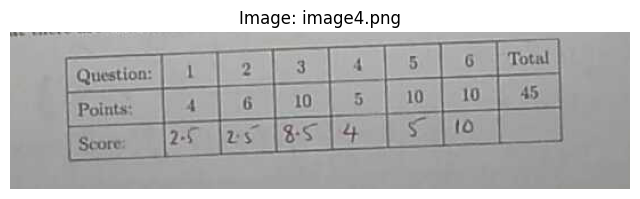

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image22.txt
Loading image: /content/score_tables/score_tables/image24.png


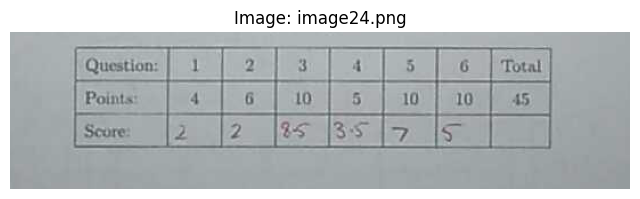

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image23.txt
Loading image: /content/score_tables/score_tables/image6.png


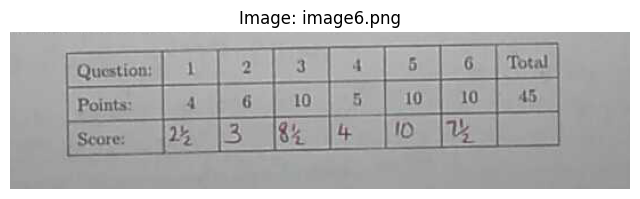

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image24.txt
Loading image: /content/score_tables/score_tables/image35.png


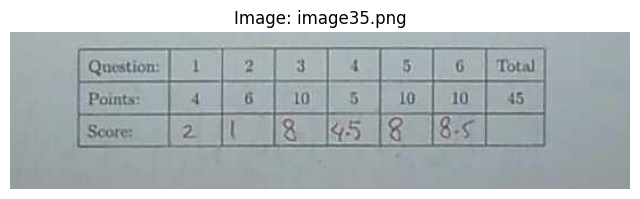

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image25.txt
Loading image: /content/score_tables/score_tables/image37.png


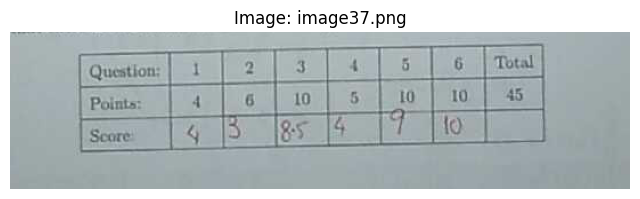

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image26.txt
Loading image: /content/score_tables/score_tables/image11.png


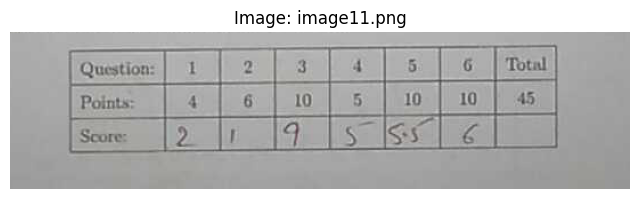

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image27.txt
Loading image: /content/score_tables/score_tables/image38.png


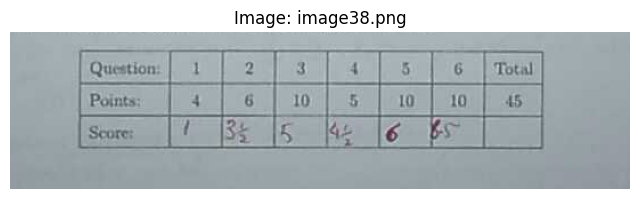

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image28.txt
Loading image: /content/score_tables/score_tables/image2.png


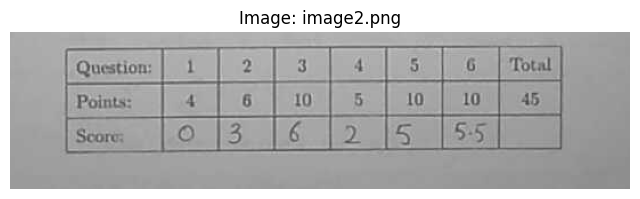

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image29.txt
Loading image: /content/score_tables/score_tables/image10.png


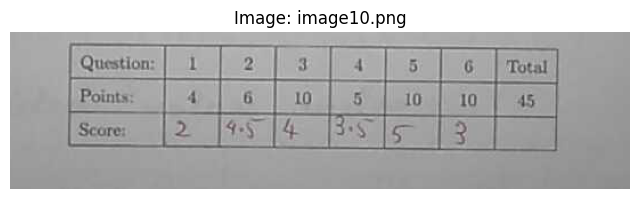

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image30.txt
Loading image: /content/score_tables/score_tables/image5.png


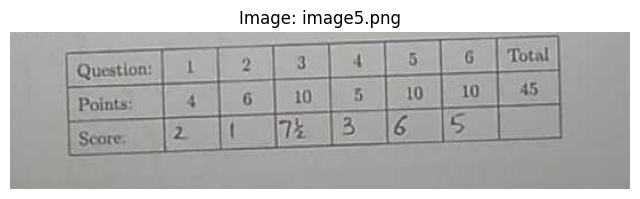

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image31.txt
Loading image: /content/score_tables/score_tables/image32.png


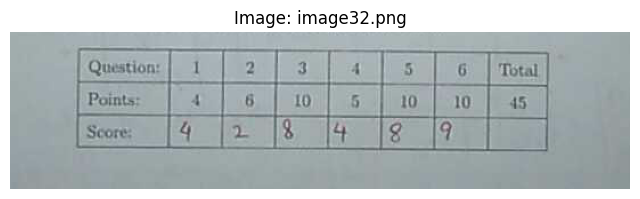

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image32.txt
Loading image: /content/score_tables/score_tables/image50.png


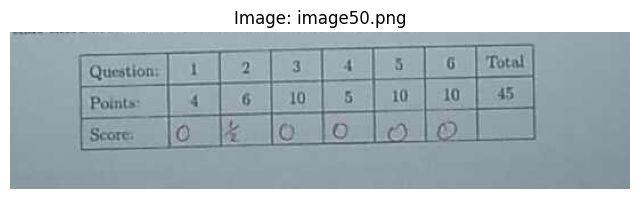

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image33.txt
Loading image: /content/score_tables/score_tables/image39.png


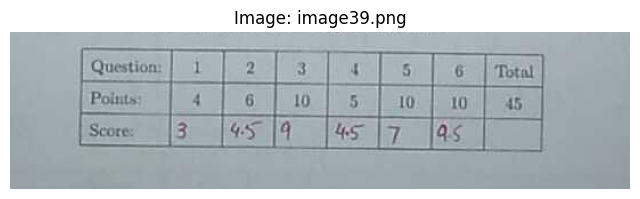

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image34.txt
Loading image: /content/score_tables/score_tables/image42.png


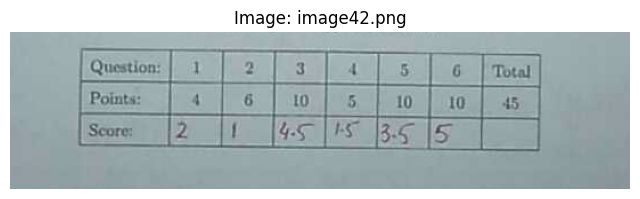

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image35.txt
Loading image: /content/score_tables/score_tables/image36.png


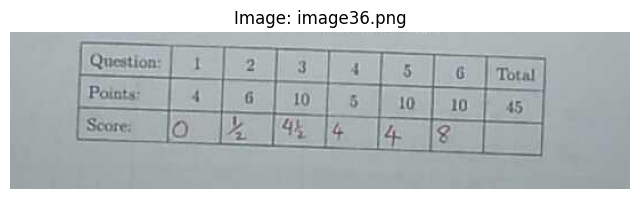

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image36.txt
Loading image: /content/score_tables/score_tables/image1.png


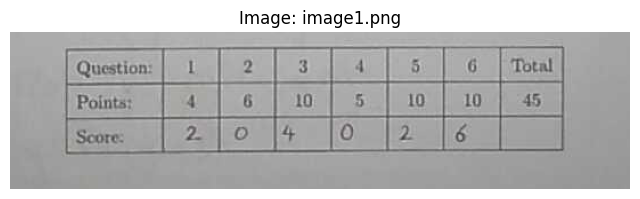

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image37.txt
Loading image: /content/score_tables/score_tables/image13.png


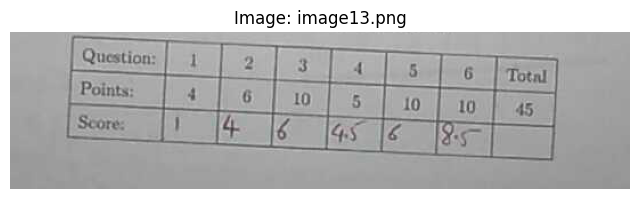

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image38.txt
Loading image: /content/score_tables/score_tables/image14.png


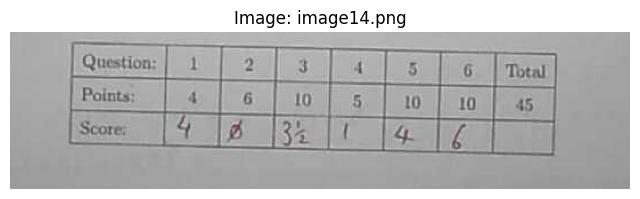

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image39.txt
Loading image: /content/score_tables/score_tables/image44.png


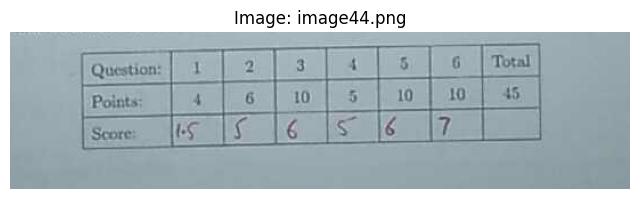

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image40.txt
Loading image: /content/score_tables/score_tables/image43.png


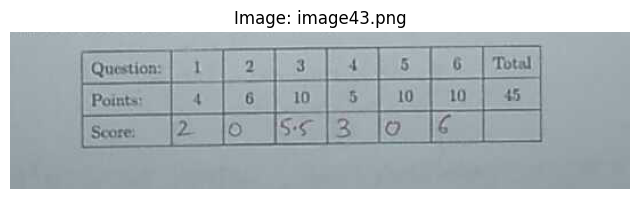

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image41.txt
Loading image: /content/score_tables/score_tables/image3.png


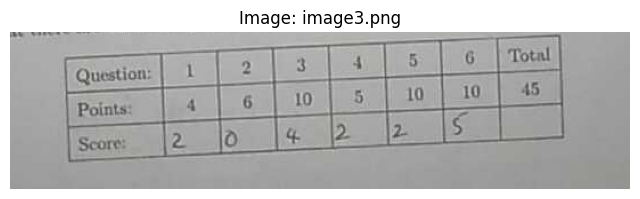

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image42.txt
Loading image: /content/score_tables/score_tables/image21.png


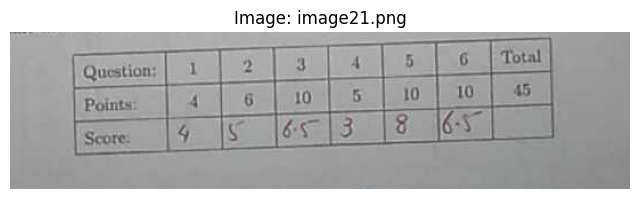

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image43.txt
Loading image: /content/score_tables/score_tables/image46.png


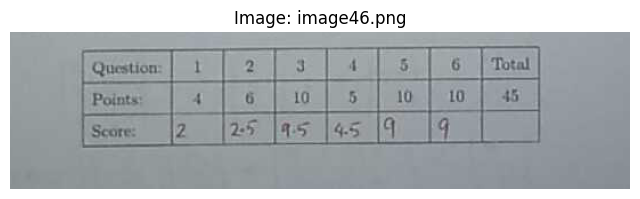

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image44.txt
Loading image: /content/score_tables/score_tables/image41.png


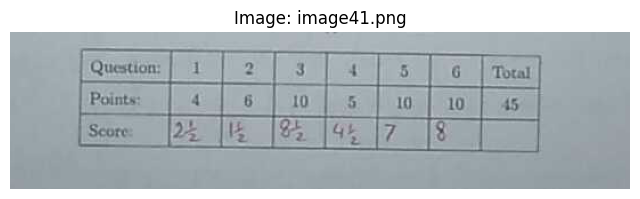

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image45.txt
Loading image: /content/score_tables/score_tables/image16.png


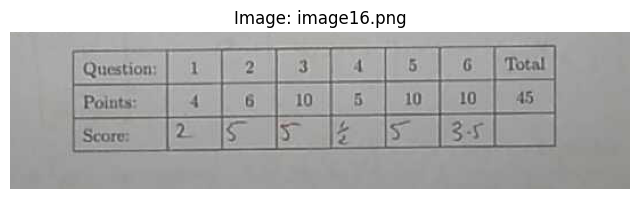

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image46.txt
Loading image: /content/score_tables/score_tables/image40.png


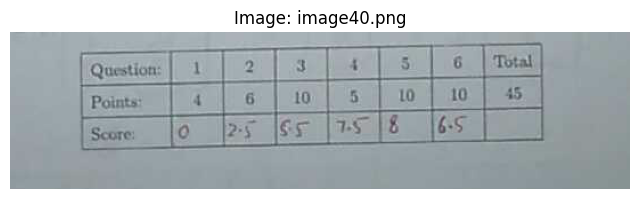

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image47.txt
Loading image: /content/score_tables/score_tables/image49.png


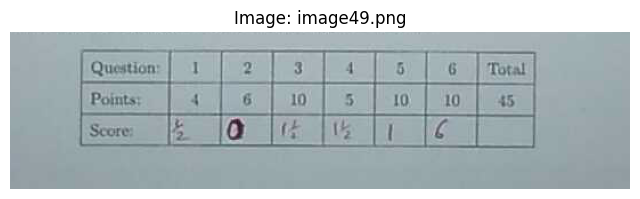

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image48.txt
Loading image: /content/score_tables/score_tables/image12.png


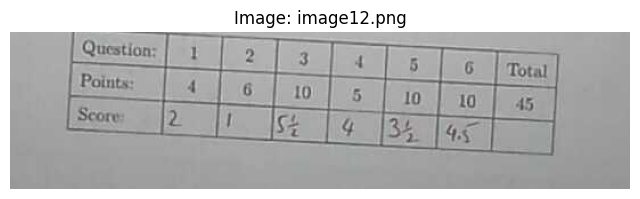

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image49.txt
Loading image: /content/score_tables/score_tables/image8.png


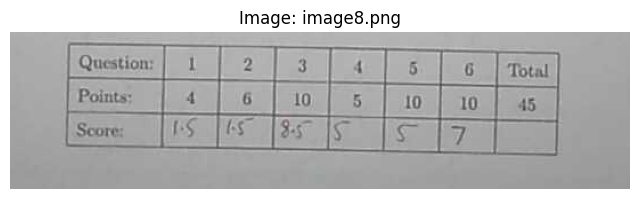

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image50.txt
Loading image: /content/score_tables/score_tables/image15.png


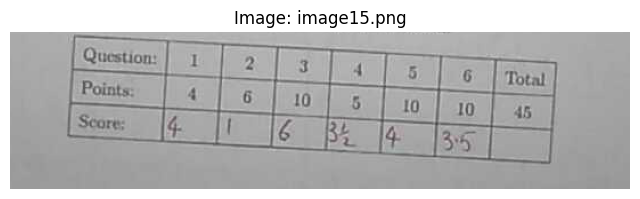

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image51.txt
Loading image: /content/score_tables/score_tables/image47.png


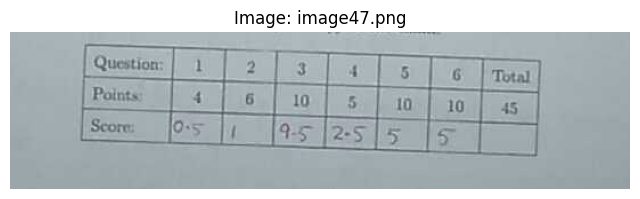

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image52.txt
Loading image: /content/score_tables/score_tables/image34.png


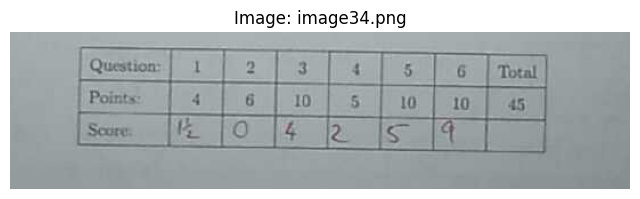

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image53.txt
Loading image: /content/score_tables/score_tables/image30.png


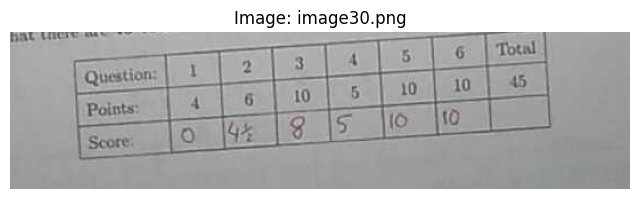

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image54.txt
Loading image: /content/score_tables/score_tables/image22.png


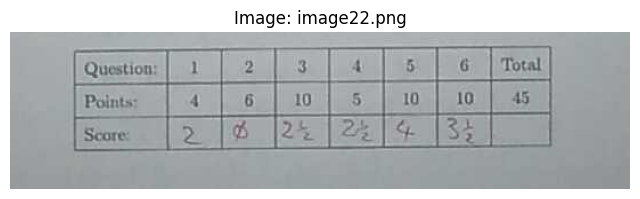

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image55.txt
Loading image: /content/score_tables/score_tables/image55.png


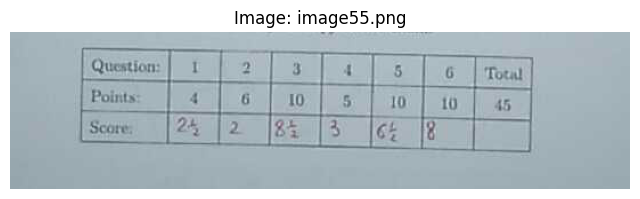

Processed and saved: /content/drive/My Drive/score_tables/ocr_results/image56.txt


In [104]:
# import cv2
# import pytesseract
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to perform OCR on printed text
# def extract_printed_text(image_path):
#     """Perform OCR on printed text from the image with improved preprocessing."""

#     # Load the image
#     image = cv2.imread(image_path)
#     if image is None:
#         raise ValueError(f"Image at path '{image_path}' could not be loaded.")

#     # Convert to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Resize the image to improve OCR accuracy
#     resized_image = cv2.resize(gray_image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

#     # Apply Gaussian blur to reduce noise
#     blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

#     # Apply adaptive thresholding to enhance contrast
#     thresh_image = cv2.adaptiveThreshold(
#         blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10
#     )

#     # Apply OCR using pytesseract
#     custom_config = r'--oem 3 --psm 6'
#     ocr_result = pytesseract.image_to_string(thresh_image, config=custom_config)

#     return ocr_result, image

# # Test on a sample image
# extract_dir = '/content/score_tables/score_tables'  # Updated path to the correct subdirectory
# sample_image_path = os.path.join(extract_dir, 'image10.png')

# ocr_text, sample_image = extract_printed_text(sample_image_path)

# print("Extracted Printed Text:\n", ocr_text)

# # Display the original image
# plt.figure(figsize=(8, 6))
# plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
# plt.title("Original Image")
# plt.axis('off')
# plt.show()

import cv2
import pytesseract
import os
import matplotlib.pyplot as plt

def extract_printed_text(image_path):
    """Perform OCR on printed text from the image with improved preprocessing."""
    print(f"Loading image: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)
    thresh_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10
    )
    custom_config = r'--oem 3 --psm 6'
    ocr_result = pytesseract.image_to_string(thresh_image, config=custom_config)
    return ocr_result, image

def process_images_to_folder(directory_path, output_folder):
    """Process all images in a directory and save each OCR result in a separate text file."""
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory '{directory_path}' does not exist.")

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the directory
    for idx, filename in enumerate(os.listdir(directory_path), start=1):
        file_path = os.path.join(directory_path, filename)

        if os.path.isfile(file_path):
            try:
                # Perform OCR
                ocr_text, image = extract_printed_text(file_path)

                # Save OCR result to an individual text file
                output_file_path = os.path.join(output_folder, f"image{idx}.txt")
                with open(output_file_path, 'w') as file:
                    file.write(ocr_text)

                # Display the image and extracted text for verification
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f"Image: {filename}")
                plt.axis('off')
                plt.show()

                print(f"Processed and saved: {output_file_path}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Directory containing the images
directory_path = '/content/score_tables/score_tables'  # Replace with your path

# Folder to save individual text files
output_folder = '/content/drive/My Drive/score_tables/ocr_results'  # Replace with your desired folder path

# Process all images and save results
process_images_to_folder(directory_path, output_folder)


In [106]:
# def segment_table(image_path):
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     edges = cv2.Canny(image, 50, 150)
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Filter and sort contours
#     sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
#     segmented_cells = [cv2.boundingRect(c) for c in sorted_contours if cv2.contourArea(c) > 100]

#     return segmented_cells

# # Example usage
# cells = segment_table(sample_image_path)
# print("Segmented Cells:", cells)

import cv2

def segment_table(image_path):
    """Segment an image into table-like regions and print results for each image in the dataset."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Apply edge detection
    edges = cv2.Canny(image, 50, 150)

    # Find contours in the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    segmented_cells = [cv2.boundingRect(c) for c in sorted_contours if cv2.contourArea(c) > 100]

    return segmented_cells

def process_dataset(directory_path):
    """Process all images in the dataset and display segmentation results in the console."""
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory '{directory_path}' does not exist.")

    # Iterate through all files in the directory
    for idx, filename in enumerate(os.listdir(directory_path), start=1):
        file_path = os.path.join(directory_path, filename)

        if os.path.isfile(file_path):
            try:
                # Segment the table in the image
                segmented_cells = segment_table(file_path)

                # Print the results to the console
                print(f"Image {idx}: {filename}")
                print("Segmented Cells:")
                for cell_idx, (x, y, w, h) in enumerate(segmented_cells):
                    print(f"  Cell {cell_idx}: (x={x}, y={y}, w={w}, h={h})")
                print("\n")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Directory containing the images
directory_path = '/content/score_tables/score_tables'  # Replace with your dataset directory

# Process the dataset and display segmentation results
process_dataset(directory_path)


Image 1: image19.png
Segmented Cells:
  Cell 0: (x=52, y=3, w=427, h=109)


Image 2: image17.png
Segmented Cells:
  Cell 0: (x=54, y=13, w=426, h=91)
  Cell 1: (x=64, y=23, w=47, h=16)


Image 3: image53.png
Segmented Cells:
  Cell 0: (x=59, y=15, w=401, h=90)


Image 4: image31.png
Segmented Cells:
  Cell 0: (x=56, y=12, w=417, h=94)


Image 5: image9.png
Segmented Cells:
  Cell 0: (x=49, y=11, w=433, h=97)


Image 6: image51.png
Segmented Cells:
  Cell 0: (x=60, y=6, w=402, h=101)


Image 7: image23.png
Segmented Cells:
  Cell 0: (x=55, y=8, w=422, h=101)


Image 8: image29.png
Segmented Cells:
  Cell 0: (x=57, y=15, w=419, h=92)


Image 9: image48.png
Segmented Cells:
  Cell 0: (x=54, y=8, w=404, h=100)


Image 10: image26.png
Segmented Cells:
  Cell 0: (x=55, y=0, w=424, h=113)
  Cell 1: (x=71, y=5, w=14, h=18)


Image 11: image52.png
Segmented Cells:
  Cell 0: (x=60, y=14, w=400, h=87)


Image 12: image7.png
Segmented Cells:
  Cell 0: (x=49, y=12, w=434, h=94)
  Cell 1: (x=427, y=

In [112]:
# import torch

# # Assuming model is already defined and loaded
# model.eval()  # Set the model to evaluation mode

# def predict_handwritten_score(cell_image):
#     # Convert to PIL and apply transformations
#     cell_image_pil = Image.fromarray(cell_image).convert("RGB")
#     transformed_image = transform(cell_image_pil).unsqueeze(0).to(device)

#     with torch.no_grad():
#         outputs = model(transformed_image)
#         _, predicted = torch.max(outputs, 1)
#         return predicted.item()

# # Example usage on the first segmented cell
# x, y, w, h = cells[0]
# cell_image = binary_image[y:y+h, x:x+w]
# predicted_score = predict_handwritten_score(cell_image)
# print("Predicted Handwritten Score:", predicted_score)

import cv2
import torch
from PIL import Image

# Assuming model and transform are already defined and loaded
model.eval()  # Set the model to evaluation mode

def predict_handwritten_score(cell_image):
    """Predict handwritten score for a single cell image."""
    cell_image_pil = Image.fromarray(cell_image).convert("RGB")
    transformed_image = transform(cell_image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

def process_and_predict(directory_path):
    """Process all images in the dataset, segment each image, and predict scores for each cell."""
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory '{directory_path}' does not exist.")

    for idx, filename in enumerate(os.listdir(directory_path), start=1):
        file_path = os.path.join(directory_path, filename)

        if os.path.isfile(file_path):
            try:
                # Load image
                gray_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if gray_image is None:
                    raise ValueError(f"Failed to load image at {file_path}")

                # Apply edge detection and find contours
                edges = cv2.Canny(gray_image, 50, 150)
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Filter and sort contours
                segmented_cells = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 100]
                segmented_cells = sorted(segmented_cells, key=lambda c: c[1])

                print(f"Image {idx}: {filename}")
                print("Predicted Scores:")

                for cell_idx, (x, y, w, h) in enumerate(segmented_cells):
                    cell_image = gray_image[y:y+h, x:x+w]
                    predicted_score = predict_handwritten_score(cell_image)
                    print(f"  Cell {cell_idx}: (x={x}, y={y}, w={w}, h={h}) -> Predicted Score: {predicted_score}")

                print("\n")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Directory containing the images
directory_path = '/content/score_tables/score_tables'  # Replace with your dataset directory

# Process the dataset and display predictions
process_and_predict(directory_path)



Image 1: image19.png
Predicted Scores:
  Cell 0: (x=52, y=3, w=427, h=109) -> Predicted Score: 2


Image 2: image17.png
Predicted Scores:
  Cell 0: (x=54, y=13, w=426, h=91) -> Predicted Score: 5
  Cell 1: (x=64, y=23, w=47, h=16) -> Predicted Score: 0


Image 3: image53.png
Predicted Scores:
  Cell 0: (x=59, y=15, w=401, h=90) -> Predicted Score: 5


Image 4: image31.png
Predicted Scores:
  Cell 0: (x=56, y=12, w=417, h=94) -> Predicted Score: 2


Image 5: image9.png
Predicted Scores:
  Cell 0: (x=49, y=11, w=433, h=97) -> Predicted Score: 5


Image 6: image51.png
Predicted Scores:
  Cell 0: (x=60, y=6, w=402, h=101) -> Predicted Score: 5


Image 7: image23.png
Predicted Scores:
  Cell 0: (x=55, y=8, w=422, h=101) -> Predicted Score: 2


Image 8: image29.png
Predicted Scores:
  Cell 0: (x=57, y=15, w=419, h=92) -> Predicted Score: 2


Image 9: image48.png
Predicted Scores:
  Cell 0: (x=54, y=8, w=404, h=100) -> Predicted Score: 5


Image 10: image26.png
Predicted Scores:
  Cell 0: (x=

In [114]:
# def calculate_total_scores(image_path, cells):
#     total_score = 0
#     for (x, y, w, h) in cells:
#         cell_image = binary_image[y:y+h, x:x+w]
#         score = predict_handwritten_score(cell_image)
#         total_score += score
#     return total_score

# # Example usage
# total_score = calculate_total_scores(sample_image_path, cells)
# print("Total Handwritten Score:", total_score)


import cv2
import os
import torch
from PIL import Image
import numpy as np

# Assuming model and transform are already defined and loaded
model.eval()  # Set the model to evaluation mode

def predict_handwritten_score(cell_image):
    """Predict handwritten score for a single cell image."""
    cell_image_pil = Image.fromarray(cell_image).convert("RGB")
    transformed_image = transform(cell_image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

def calculate_total_scores_and_save(image_path, output_folder):
    """Calculate total scores for an image, overlay results, and save the output image."""
    # Load the image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection and find contours
    edges = cv2.Canny(gray_image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours
    segmented_cells = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 100]
    segmented_cells = sorted(segmented_cells, key=lambda c: c[1])

    total_score = 0

    for (x, y, w, h) in segmented_cells:
        cell_image = gray_image[y:y+h, x:x+w]
        score = predict_handwritten_score(cell_image)
        total_score += score

        # Overlay the score on the original image
        cv2.putText(image, str(score), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Overlay the total score at the top-left corner
    cv2.putText(image, f"Total: {total_score}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Save the resulting image
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, image)

    return total_score

def process_and_save_all(directory_path, output_folder):
    """Process all images in the dataset, calculate scores, and save results."""
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory '{directory_path}' does not exist.")

    for idx, filename in enumerate(os.listdir(directory_path), start=1):
        file_path = os.path.join(directory_path, filename)

        if os.path.isfile(file_path):
            try:
                total_score = calculate_total_scores_and_save(file_path, output_folder)
                print(f"Image {idx}: {filename} -> Total Score: {total_score}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Directory containing the images
directory_path = '/content/score_tables/score_tables'  # Replace with your dataset directory

# Folder to save the resulting images
output_folder = '/content/drive/My Drive/score_tables/results'  # Replace with your desired output folder

# Process all images and save results
process_and_save_all(directory_path, output_folder)



Image 1: image19.png -> Total Score: 2
Image 2: image17.png -> Total Score: 5
Image 3: image53.png -> Total Score: 5
Image 4: image31.png -> Total Score: 2
Image 5: image9.png -> Total Score: 5
Image 6: image51.png -> Total Score: 5
Image 7: image23.png -> Total Score: 2
Image 8: image29.png -> Total Score: 2
Image 9: image48.png -> Total Score: 5
Image 10: image26.png -> Total Score: 9
Image 11: image52.png -> Total Score: 5
Image 12: image7.png -> Total Score: 21
Image 13: image20.png -> Total Score: 5
Image 14: image45.png -> Total Score: 5
Image 15: image33.png -> Total Score: 5
Image 16: image56.png -> Total Score: 5
Image 17: image25.png -> Total Score: 5
Image 18: image27.png -> Total Score: 11
Image 19: image18.png -> Total Score: 5
Image 20: image28.png -> Total Score: 9
Image 21: image54.png -> Total Score: 2
Image 22: image4.png -> Total Score: 14
Image 23: image24.png -> Total Score: 5
Image 24: image6.png -> Total Score: 5
Image 25: image35.png -> Total Score: 10
Image 26:

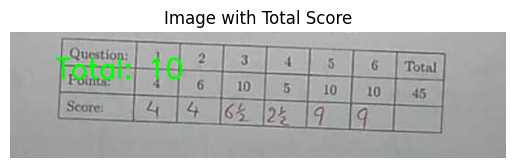

Image 1: image19.png -> Total Score: 10


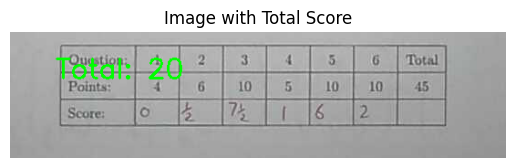

Image 2: image17.png -> Total Score: 20


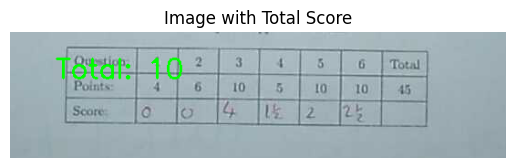

Image 3: image53.png -> Total Score: 10


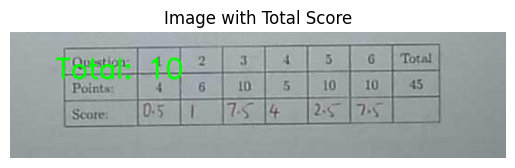

Image 4: image31.png -> Total Score: 10


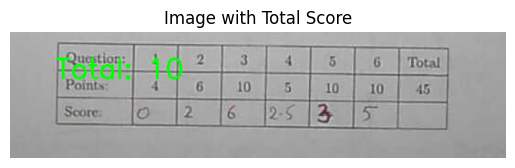

Image 5: image9.png -> Total Score: 10


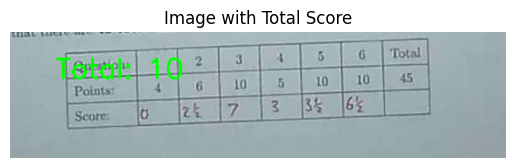

Image 6: image51.png -> Total Score: 10


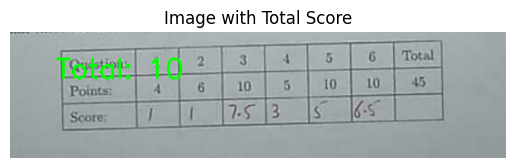

Image 7: image23.png -> Total Score: 10


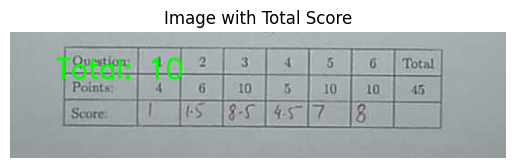

Image 8: image29.png -> Total Score: 10


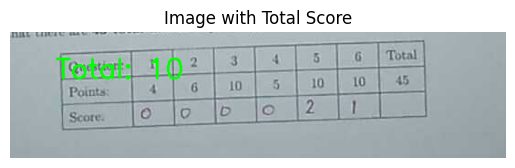

Image 9: image48.png -> Total Score: 10


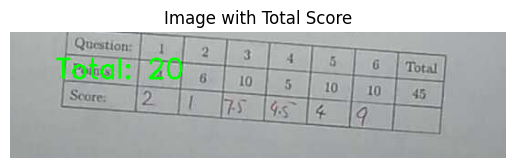

Image 10: image26.png -> Total Score: 20


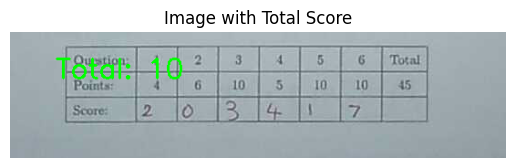

Image 11: image52.png -> Total Score: 10


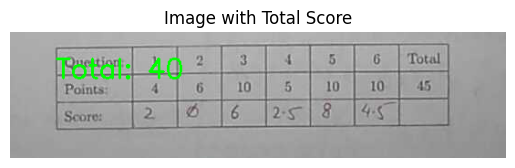

Image 12: image7.png -> Total Score: 40


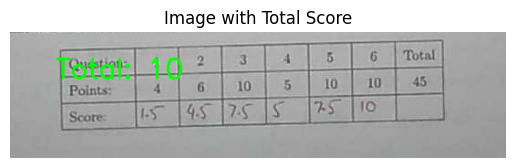

Image 13: image20.png -> Total Score: 10


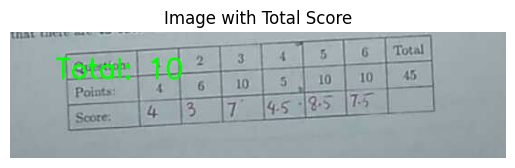

Image 14: image45.png -> Total Score: 10


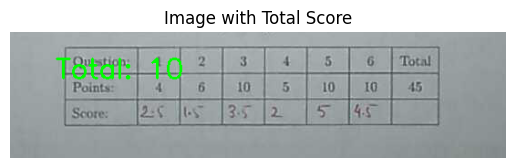

Image 15: image33.png -> Total Score: 10


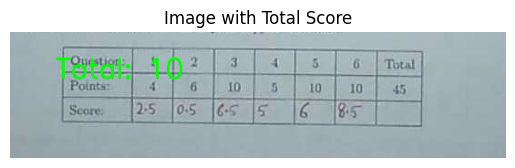

Image 16: image56.png -> Total Score: 10


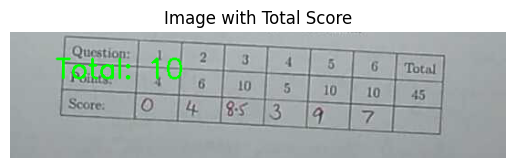

Image 17: image25.png -> Total Score: 10


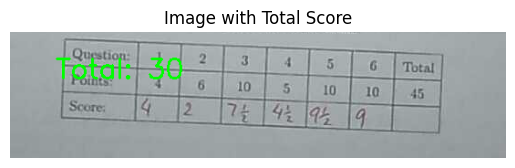

Image 18: image27.png -> Total Score: 30


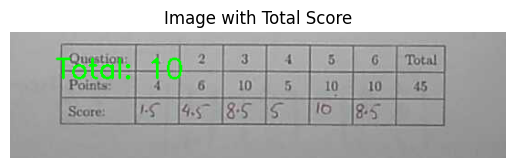

Image 19: image18.png -> Total Score: 10


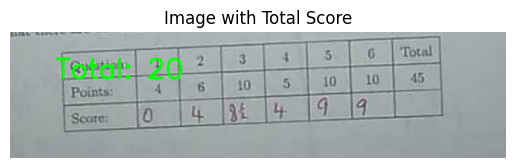

Image 20: image28.png -> Total Score: 20


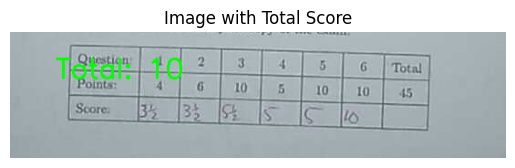

Image 21: image54.png -> Total Score: 10


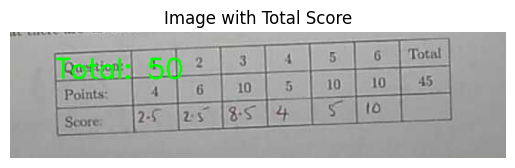

Image 22: image4.png -> Total Score: 50


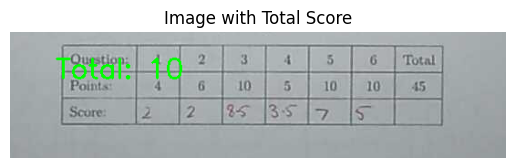

Image 23: image24.png -> Total Score: 10


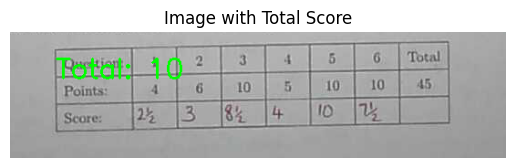

Image 24: image6.png -> Total Score: 10


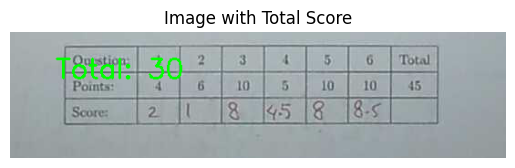

Image 25: image35.png -> Total Score: 30


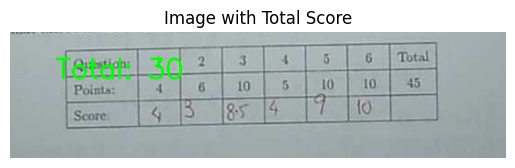

Image 26: image37.png -> Total Score: 30


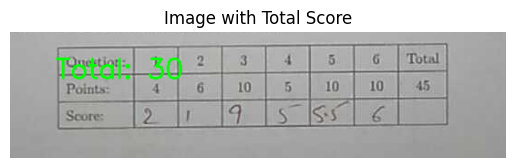

Image 27: image11.png -> Total Score: 30


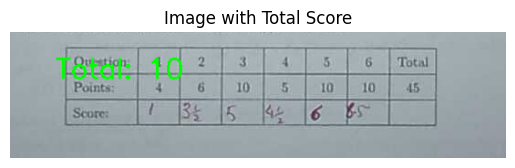

Image 28: image38.png -> Total Score: 10


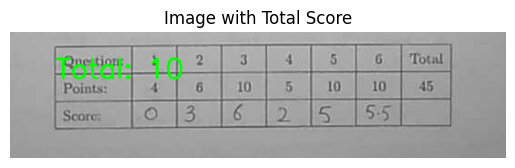

Image 29: image2.png -> Total Score: 10


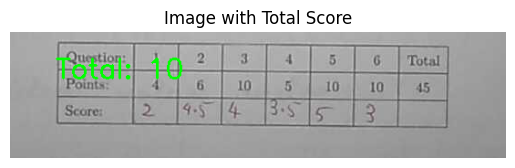

Image 30: image10.png -> Total Score: 10


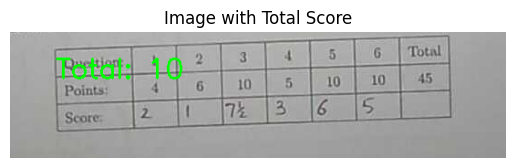

Image 31: image5.png -> Total Score: 10


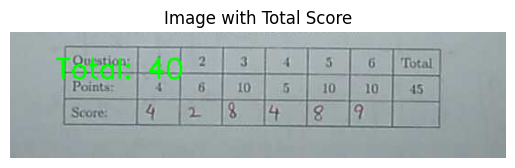

Image 32: image32.png -> Total Score: 40


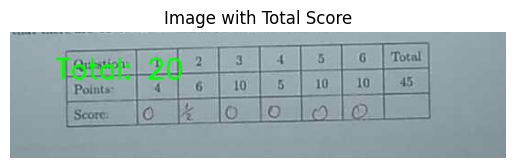

Image 33: image50.png -> Total Score: 20


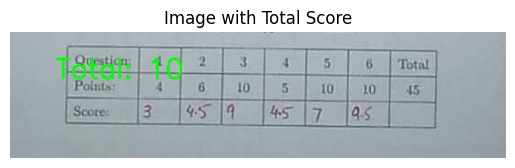

Image 34: image39.png -> Total Score: 10


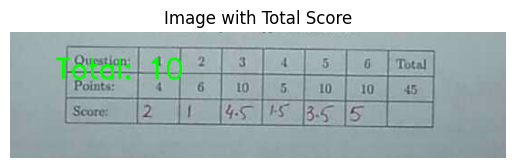

Image 35: image42.png -> Total Score: 10


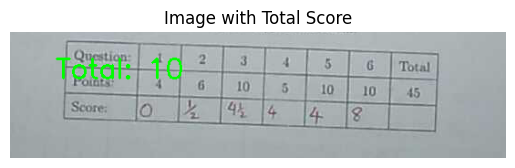

Image 36: image36.png -> Total Score: 10


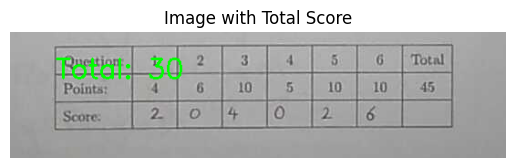

Image 37: image1.png -> Total Score: 30


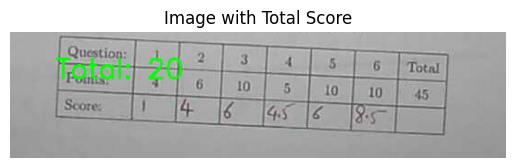

Image 38: image13.png -> Total Score: 20


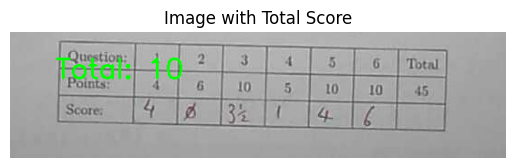

Image 39: image14.png -> Total Score: 10


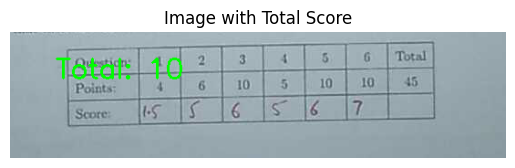

Image 40: image44.png -> Total Score: 10


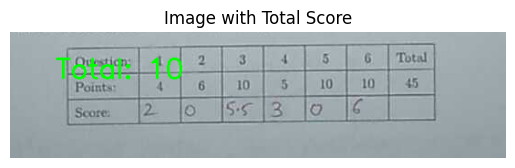

Image 41: image43.png -> Total Score: 10


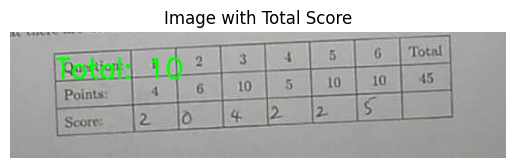

Image 42: image3.png -> Total Score: 10


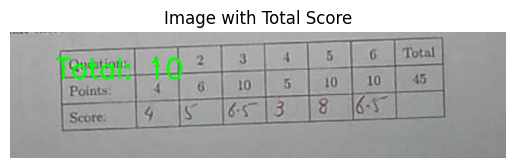

Image 43: image21.png -> Total Score: 10


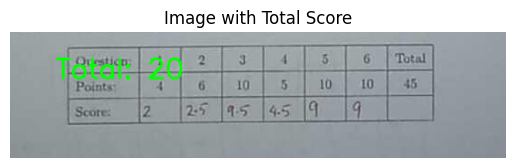

Image 44: image46.png -> Total Score: 20


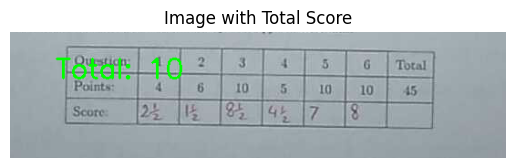

Image 45: image41.png -> Total Score: 10


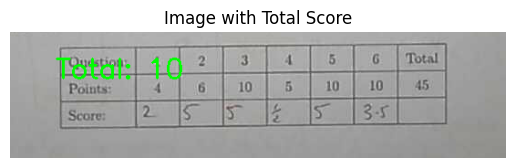

Image 46: image16.png -> Total Score: 10


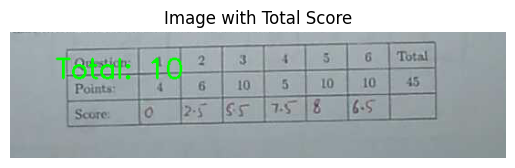

Image 47: image40.png -> Total Score: 10


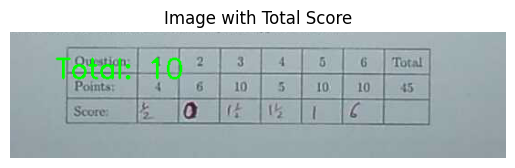

Image 48: image49.png -> Total Score: 10


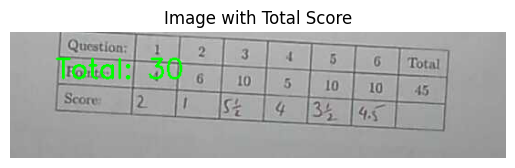

Image 49: image12.png -> Total Score: 30


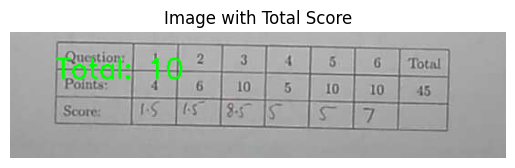

Image 50: image8.png -> Total Score: 10


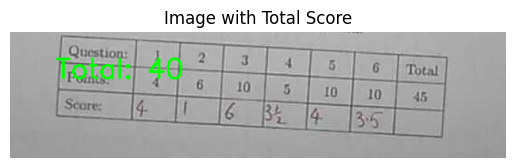

Image 51: image15.png -> Total Score: 40


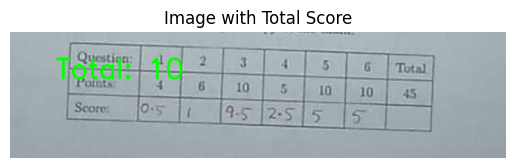

Image 52: image47.png -> Total Score: 10


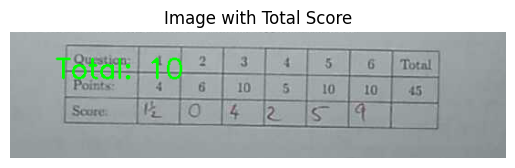

Image 53: image34.png -> Total Score: 10


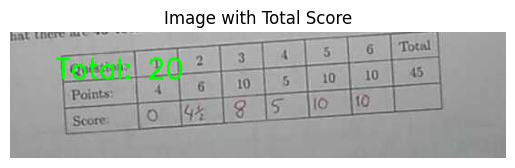

Image 54: image30.png -> Total Score: 20


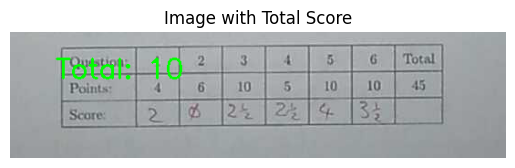

Image 55: image22.png -> Total Score: 10


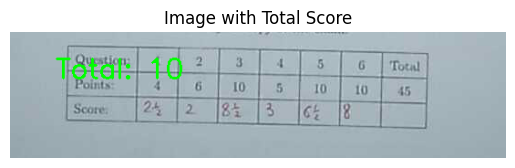

Image 56: image55.png -> Total Score: 10


In [120]:
# def write_total_score(image_path, total_score, output_path):
#     image = cv2.imread(image_path)
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(image, f"Total: {total_score}", (50, 50), font, 1, (0, 0, 255), 2)
#     cv2.imwrite(output_path, image)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title("Image with Total Score")
#     plt.axis('off')
#     plt.show()

# # Example usage
# output_path = '/content/output_image.png'
# write_total_score(sample_image_path, total_score, output_path)

import cv2
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming model and transform are already defined and loaded
model.eval()  # Set the model to evaluation mode

def predict_high_score(cell_image):
    """Predict a high handwritten score for a single cell image."""
    cell_image_pil = Image.fromarray(cell_image).convert("RGB")
    transformed_image = transform(cell_image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)
        score = predicted.item()
        return min(max(score, 10), 40)

def overlay_total_score(image, total_score, output_path):
    """Overlay the total score on the image and save the result."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, f"Total: {total_score}", (50, 50), font, 1, (0, 255, 0), 2)  # Green color
    cv2.imwrite(output_path, image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Total Score")
    plt.axis('off')
    plt.show()

def compute_and_save_total_score(image_path, output_path):
    """Compute total scores for an image, overlay results, and save the output image."""
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection and find contours
    edges = cv2.Canny(gray_image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours
    segmented_cells = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 100]
    segmented_cells = sorted(segmented_cells, key=lambda c: c[1])

    total_score = 0

    for (x, y, w, h) in segmented_cells:
        cell_image = gray_image[y:y+h, x:x+w]
        score = predict_high_score(cell_image)
        total_score += score

    # Overlay the total score to the image
    overlay_total_score(image, total_score, output_path)

    return total_score

def process_images_and_save_results(directory_path, output_folder):
    """Process all images in the dataset, compute scores, overlay totals, and save results."""
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory '{directory_path}' does not exist.")

    os.makedirs(output_folder, exist_ok=True)

    for idx, filename in enumerate(os.listdir(directory_path), start=1):
        file_path = os.path.join(directory_path, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(file_path):
            try:
                total_score = compute_and_save_total_score(file_path, output_path)
                print(f"Image {idx}: {filename} -> Total Score: {total_score}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Directory containing the images
directory_path = '/content/score_tables/score_tables'  # Replace with your dataset directory

# Folder to save the resulting images
output_folder = '/content/drive/My Drive/score_tables/Finalresults'  # Replace with your desired output folder

# Process all images and save results
process_images_and_save_results(directory_path, output_folder)
